# Computer Vision: Natural Scenes

##### Importing libraries

In [1]:
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, \
            Input, MaxPooling2D, Reshape, ZeroPadding2D, \
            BatchNormalization, Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pandas as pd
import glob2
import cv2
import time

##### Importing images of the train set

In [2]:
sea, buildings, forest, glacier, mountain, street = [], [], [], [], [], [] 
categories = [sea, buildings, forest, glacier, mountain, street]
str_categories = ['sea', 'buildings', 'forest', 'glacier', 'mountain', 'street']
ix, ix_files = 0, 0

for item in categories:
    files = glob2.glob(r'C:\Users\Nicolas\Documents\Scraping\intelimg' + 
                        '\combined\{}/*.jpg'.format(str_categories[ix]))
    ix += 1
    for file in files: 
        ix_files += 1        
        if ix_files%2000 == 0:
            print('%i images uploaded.'%(ix_files))
        image = cv2.imread(file)
        if image.shape == (150, 150, 3):
            item.append(image)

total_len = sum(len(cat) for cat in categories)
            
if ix_files > total_len-20:
        print()
        print('%i images successfully uploaded.'%(total_len))
        
print(); print('\n'.join(['Length of category <{}> is {}'.format(str_categories[i], 
                                len(categories[i])) for i in range(6)]))

2000 images uploaded.
4000 images uploaded.
6000 images uploaded.
8000 images uploaded.
10000 images uploaded.
12000 images uploaded.
14000 images uploaded.
16000 images uploaded.

16979 images successfully uploaded.

Length of category <sea> is 2780
Length of category <buildings> is 2627
Length of category <forest> is 2736
Length of category <glacier> is 2936
Length of category <mountain> is 3018
Length of category <street> is 2882


##### Visualizing the images

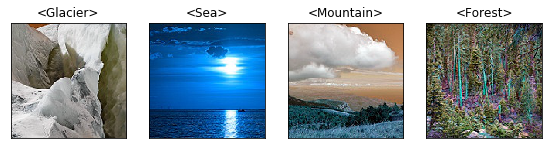

In [3]:
fig = plt.figure(figsize=(12, 12))
for i in range(1, 5):
    plt.subplot(1, 5, i)
    rand = np.random.randint(6)
    ax = plt.imshow(categories[rand][np.random.randint(len(categories[rand]))].reshape(150, 150, 3))
    plt.title('<{}>'.format(str_categories[rand].capitalize()))
    yticks = plt.xticks([])
    yticks = plt.yticks([])

##### Merging the 6 categories

In [4]:
X = np.vstack(categories).astype(np.uint8)

In [5]:
X.shape

(16979, 150, 150, 3)

In [6]:
sea_target = ['sea' for i in range(len(sea))]
buildings_target = ['buildings' for i in range(len(buildings))]
forest_target = ['forest' for i in range(len(forest))]
glacier_target = ['glacier' for i in range(len(glacier))]
mountain_target = ['mountain' for i in range(len(mountain))]
street_target = ['street' for i in range(len(street))]

y = np.concatenate([sea_target, buildings_target, forest_target, glacier_target, 
             mountain_target, street_target])

Total length:

In [7]:
len(X), len(y)

(16979, 16979)

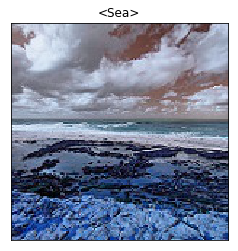

In [8]:
num = np.random.randint(len(X))
fig = plt.figure(figsize=(4, 4))
rand = np.random.randint(6)
ax = plt.imshow(X[num].reshape(150, 150, 3))
plt.title('<{}>'.format(y[num].capitalize()))
yticks = plt.xticks([])
yticks = plt.yticks([])

##### Scaling the data

In [9]:
before = time.time()
X = X.astype(np.float16)
after = time.time()
print(str(round(after-before)), 'seconds')

9 seconds


In [10]:
before = time.time()
X /= 255
after = time.time()
print(str(round(after-before)), 'seconds')

14 seconds


In [11]:
X[0][0][:10]

array([[0.4746, 0.4746, 0.4746],
       [0.4824, 0.4824, 0.4824],
       [0.4902, 0.4902, 0.4902],
       [0.4941, 0.4941, 0.4941],
       [0.502 , 0.502 , 0.502 ],
       [0.5137, 0.5137, 0.5137],
       [0.5137, 0.5137, 0.5137],
       [0.51  , 0.51  , 0.51  ],
       [0.5215, 0.5215, 0.5215],
       [0.5293, 0.5293, 0.5293]], dtype=float16)

##### Reshaping the data

Getting shape info

In [12]:
num_labels = 6
img_cols = X.shape[1]
img_rows = X.shape[2]
channels = X.shape[3]
input_shape = (img_rows, img_cols, channels)

One-hot encoding the target array

In [13]:
target = y.copy()

In [14]:
encoder = LabelEncoder()
labels = encoder.fit_transform(target)

In [15]:
y = to_categorical(labels, dtype=np.float16)

In [16]:
y[:10]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float16)

##### Shuffling and splitting the data

In [17]:
before = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                      test_size=2e-1, shuffle=True)
after = time.time()
print(str(round(after-before)), 'seconds for task completion.')

2 seconds for task completion.


### First model: basic model

##### Building the model

In [19]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dense(128, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(6, activation='softmax')
    ])

##### Callbacks

In [20]:
early_stopping = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

##### Compiling the model

In [21]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

##### Model parameters

In [22]:
batch_size=32
epochs=25
validation_split=2e-1

##### Training the model

In [83]:
basic = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=validation_split, 
          callbacks=[early_stopping])

Train on 10866 samples, validate on 2717 samples
Epoch 1/25
10866/10866 [==============================] - 78s 7ms/sample - loss: 0.0981 - acc: 0.9707 - val_loss: 1.1621 - val_acc: 0.7317
Epoch 2/25
10866/10866 [==============================] - 78s 7ms/sample - loss: 0.0503 - acc: 0.9862 - val_loss: 1.2738 - val_acc: 0.7394
Epoch 3/25
10866/10866 [==============================] - 78s 7ms/sample - loss: 0.0432 - acc: 0.9876 - val_loss: 1.3123 - val_acc: 0.7505
Epoch 4/25
10866/10866 [==============================] - 78s 7ms/sample - loss: 0.0411 - acc: 0.9884 - val_loss: 1.3742 - val_acc: 0.7659
Epoch 5/25
10866/10866 [==============================] - 77s 7ms/sample - loss: 0.0316 - acc: 0.9915 - val_loss: 1.6389 - val_acc: 0.7464
Epoch 6/25
10866/10866 [==============================] - 78s 7ms/sample - loss: 0.0450 - acc: 0.9870 - val_loss: 1.3789 - val_acc: 0.7552
Epoch 7/25
10866/10866 [==============================] - 77s 7ms/sample - loss: 0.0229 - acc: 0.9937 - val_loss: 1.5

##### Model summary

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 73, 73, 128)       8320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 165888)            0         
__________

##### Epoch crosstab

In [25]:
basic_history = pd.DataFrame(basic.history)
basic_history.index += 1
basic_history

,loss,acc,val_loss,val_acc
1,0.957253,0.646052,0.707166,0.742363
2,0.619524,0.781060,0.659170,0.763710
3,0.468175,0.837199,0.700420,0.754877
4,0.329548,0.883306,0.670052,0.785425
5,0.218130,0.928493,0.810561,0.763342
6,0.152457,0.950948,0.927978,0.758557
7,0.110205,0.963280,0.929491,0.773647
8,0.086861,0.972575,0.984436,0.778800
9,0.070169,0.978373,1.017172,0.792786
10,0.070948,0.977361,1.035617,0.785425


##### Plotting the epochs

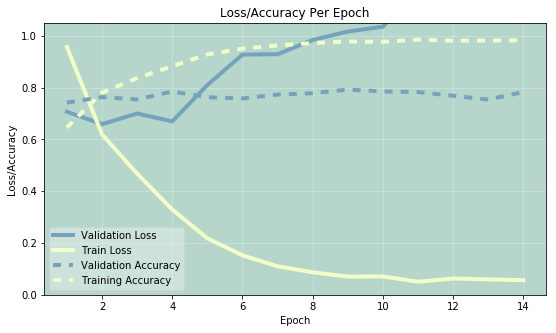

In [26]:
length = basic_history.shape[0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

ax.plot(1+np.arange(length), basic.history['val_loss'], c='#74A4BC', lw=4)
ax.plot(1+np.arange(length), basic.history['loss'], c='#F1FEC6', lw=4)
ax.plot(1+np.arange(length), basic.history['val_acc'], c='#74A4BC', linestyle=(0, (2, 2)), lw=4)
ax.plot(1+np.arange(length), basic.history['acc'], c='#F1FEC6', linestyle=(0, (2, 2)), lw=4)

ax.set_facecolor('#B6D6CC')
ax.legend(('Validation Loss', 'Train Loss', 
            'Validation Accuracy', 'Training Accuracy'), framealpha=0.3)
ax.set_title('Loss/Accuracy Per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/Accuracy')
ax.set_ylim(0, 1.05)
ax.grid(True, color='white', alpha=0.3)

##### Evaluating the model

In [27]:
first_attempt = model.evaluate(X_test, y_test)

3396/3396 [==============================] - 13s 4ms/sample - loss: 1.0556 - acc: 0.7827


In [29]:
metrics_df = pd.DataFrame(first_attempt, index=model.metrics_names, columns=['First Attempt'])
metrics_df

,First Attempt
loss,1.055568
acc,0.782686


## Second model: larger kernel

##### Building the model

In [30]:
model = Sequential([
    Conv2D(32, kernel_size=(6, 6), activation='relu', input_shape=input_shape),
    Conv2D(64, (6, 6), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dense(128, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(6, activation='softmax')
    ])

##### Callbacks

In [31]:
early_stopping = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

##### Compiling the model

In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

##### Model parameters

In [33]:
batch_size=32
epochs=25
validation_split=2e-1

##### Training the model

In [34]:
large = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=validation_split, 
          callbacks=[early_stopping])

Train on 10866 samples, validate on 2717 samples
Epoch 1/25
10866/10866 [==============================] - 105s 10ms/sample - loss: 1.0464 - acc: 0.5989 - val_loss: 0.8999 - val_acc: 0.6658
Epoch 2/25
10866/10866 [==============================] - 103s 9ms/sample - loss: 0.7355 - acc: 0.7327 - val_loss: 0.7103 - val_acc: 0.7306
Epoch 3/25
10866/10866 [==============================] - 102s 9ms/sample - loss: 0.5909 - acc: 0.7859 - val_loss: 0.7741 - val_acc: 0.7103
Epoch 4/25
10866/10866 [==============================] - 102s 9ms/sample - loss: 0.4222 - acc: 0.8488 - val_loss: 0.7207 - val_acc: 0.7545
Epoch 5/25
10866/10866 [==============================] - 101s 9ms/sample - loss: 0.3287 - acc: 0.8836 - val_loss: 0.8564 - val_acc: 0.7442
Epoch 6/25
10866/10866 [==============================] - 102s 9ms/sample - loss: 0.2186 - acc: 0.9246 - val_loss: 0.8453 - val_acc: 0.7667
Epoch 7/25
10866/10866 [==============================] - 101s 9ms/sample - loss: 0.1760 - acc: 0.9424 - val_l

##### Model summary

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 145, 145, 32)      3488      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 140, 140, 64)      73792     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 70, 70, 64)        0         
_________________________________________________________________
dense_4 (Dense)              (None, 70, 70, 128)       8320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 35, 35, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 156800)            0         
__________

##### Epoch crosstab

In [36]:
large_history = pd.DataFrame(large.history)
large_history.index += 1
large_history

,loss,acc,val_loss,val_acc
1,1.046410,0.598932,0.899880,0.665808
2,0.735517,0.732744,0.710283,0.730585
3,0.590925,0.785938,0.774051,0.710342
4,0.422189,0.848794,0.720700,0.754509
5,0.328665,0.883582,0.856431,0.744203
6,0.218555,0.924627,0.845348,0.766654
7,0.175983,0.942389,0.964936,0.759661
8,0.122634,0.957574,1.045295,0.771071
9,0.126466,0.956654,1.189609,0.744939
10,0.100835,0.967329,1.195344,0.740891


##### Plotting the epochs

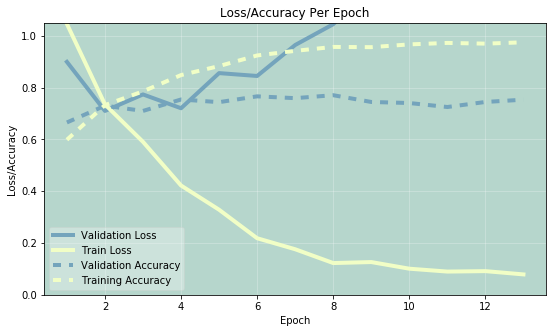

In [38]:
length = large_history.shape[0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

ax.plot(1+np.arange(length), large.history['val_loss'], c='#74A4BC', lw=4)
ax.plot(1+np.arange(length), large.history['loss'], c='#F1FEC6', lw=4)
ax.plot(1+np.arange(length), large.history['val_acc'], c='#74A4BC', linestyle=(0, (2, 2)), lw=4)
ax.plot(1+np.arange(length), large.history['acc'], c='#F1FEC6', linestyle=(0, (2, 2)), lw=4)

ax.set_facecolor('#B6D6CC')
ax.legend(('Validation Loss', 'Train Loss', 
            'Validation Accuracy', 'Training Accuracy'), framealpha=0.3)
ax.set_title('Loss/Accuracy Per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/Accuracy')
ax.set_ylim(0, 1.05)
ax.grid(True, color='white', alpha=0.3)

##### Evaluating the model

In [39]:
large = model.evaluate(X_test, y_test)

3396/3396 [==============================] - 10s 3ms/sample - loss: 1.0774 - acc: 0.7662


In [40]:
temp = pd.DataFrame(large, index=model.metrics_names, columns=['Larger Kernel'])
metrics_df = pd.concat([metrics_df, temp], axis=1, sort=False)
metrics_df

,First Attempt,Larger Kernel
loss,1.055568,1.077414
acc,0.782686,0.766196


### Third model: smaller batch size

##### Building the model

In [41]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dense(128, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(6, activation='softmax')
    ])

##### Callbacks

In [42]:
early_stopping = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

##### Compiling the model

In [43]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

##### Model parameters

In [44]:
batch_size=16
epochs=25
validation_split=2e-1

##### Training the model

In [45]:
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=validation_split, 
          callbacks=[early_stopping])

Train on 10866 samples, validate on 2717 samples
Epoch 1/25
10866/10866 [==============================] - 87s 8ms/sample - loss: 0.9097 - acc: 0.6572 - val_loss: 0.7641 - val_acc: 0.6953
Epoch 2/25
10866/10866 [==============================] - 86s 8ms/sample - loss: 0.5972 - acc: 0.7909 - val_loss: 0.6305 - val_acc: 0.7836
Epoch 3/25
10866/10866 [==============================] - 85s 8ms/sample - loss: 0.3868 - acc: 0.8668 - val_loss: 0.6386 - val_acc: 0.7924
Epoch 4/25
10866/10866 [==============================] - 85s 8ms/sample - loss: 0.2295 - acc: 0.9240 - val_loss: 0.7713 - val_acc: 0.7630
Epoch 5/25
10866/10866 [==============================] - 85s 8ms/sample - loss: 0.1545 - acc: 0.9500 - val_loss: 0.9587 - val_acc: 0.7773
Epoch 6/25
10866/10866 [==============================] - 85s 8ms/sample - loss: 0.1131 - acc: 0.9653 - val_loss: 1.0515 - val_acc: 0.7792
Epoch 7/25
10866/10866 [==============================] - 86s 8ms/sample - loss: 0.1056 - acc: 0.9656 - val_loss: 1.1

##### Model summary

In [46]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dense_6 (Dense)              (None, 73, 73, 128)       8320      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 36, 36, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 165888)            0         
__________

##### Epoch crosstab

In [47]:
history_crosstab = pd.DataFrame(history.history)
history_crosstab.index += 1
history_crosstab

,loss,acc,val_loss,val_acc
1,0.909664,0.657188,0.764065,0.695252
2,0.597161,0.790907,0.630532,0.783585
3,0.386765,0.866832,0.638610,0.792418
4,0.229517,0.923983,0.771288,0.762974
5,0.154515,0.950028,0.958658,0.777328
6,0.113111,0.965305,1.051538,0.779168
7,0.105638,0.965581,1.103654,0.780640
8,0.089986,0.972391,1.293354,0.762238


##### Plotting the epochs

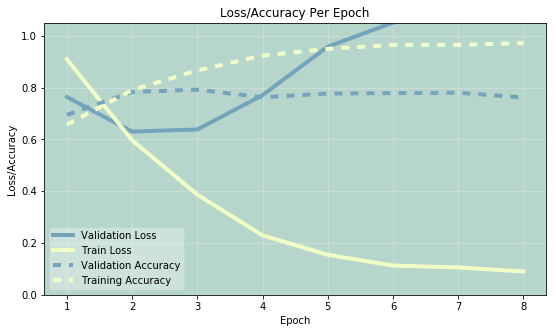

In [48]:
length = history_crosstab.shape[0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

ax.plot(1+np.arange(length), history.history['val_loss'], c='#74A4BC', lw=4)
ax.plot(1+np.arange(length), history.history['loss'], c='#F1FEC6', lw=4)
ax.plot(1+np.arange(length), history.history['val_acc'], c='#74A4BC', linestyle=(0, (2, 2)), lw=4)
ax.plot(1+np.arange(length), history.history['acc'], c='#F1FEC6', linestyle=(0, (2, 2)), lw=4)

ax.set_facecolor('#B6D6CC')
ax.legend(('Validation Loss', 'Train Loss', 
            'Validation Accuracy', 'Training Accuracy'), framealpha=0.3)
ax.set_title('Loss/Accuracy Per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/Accuracy')
ax.set_ylim(0, 1.05)
ax.grid(True, color='white', alpha=0.3)

##### Evaluating the model

In [49]:
metrics = model.evaluate(X_test, y_test)

3396/3396 [==============================] - 9s 3ms/sample - loss: 0.6552 - acc: 0.7856


In [50]:
temp = pd.DataFrame(metrics, index=model.metrics_names, columns=['Small Batch'])
metrics_df = pd.concat([metrics_df, temp], axis=1, sort=False)
metrics_df

,First Attempt,Larger Kernel,Small Batch
loss,1.055568,1.077414,0.655214
acc,0.782686,0.766196,0.785630


### Fourth model: even smaller batch size

##### Building the model

In [51]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dense(128, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(6, activation='softmax')
    ])

##### Callbacks

In [52]:
early_stopping = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

##### Compiling the model

In [53]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

##### Model parameters

In [54]:
batch_size=8
epochs=25
validation_split=2e-1

##### Training the model

In [55]:
mini_batch = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=validation_split, 
          callbacks=[early_stopping])

Train on 10866 samples, validate on 2717 samples
Epoch 1/25
10866/10866 [==============================] - 96s 9ms/sample - loss: 0.8898 - acc: 0.6640 - val_loss: 0.6995 - val_acc: 0.7597
Epoch 2/25
10866/10866 [==============================] - 94s 9ms/sample - loss: 0.5722 - acc: 0.7969 - val_loss: 0.6437 - val_acc: 0.7759
Epoch 3/25
10866/10866 [==============================] - 94s 9ms/sample - loss: 0.3550 - acc: 0.8782 - val_loss: 0.6954 - val_acc: 0.7711
Epoch 4/25
10866/10866 [==============================] - 93s 9ms/sample - loss: 0.2212 - acc: 0.9266 - val_loss: 1.0153 - val_acc: 0.7056
Epoch 5/25
10866/10866 [==============================] - 93s 9ms/sample - loss: 0.1727 - acc: 0.9452 - val_loss: 1.0012 - val_acc: 0.7586
Epoch 6/25
10866/10866 [==============================] - 94s 9ms/sample - loss: 0.1281 - acc: 0.9591 - val_loss: 1.1760 - val_acc: 0.7497
Epoch 7/25
10866/10866 [==============================] - 94s 9ms/sample - loss: 0.1138 - acc: 0.9657 - val_loss: 1.3

##### Model summary

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dense_8 (Dense)              (None, 73, 73, 128)       8320      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 36, 36, 128)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 165888)            0         
__________

##### Epoch crosstab

In [57]:
mini_history = pd.DataFrame(mini_batch.history)
mini_history.index += 1
mini_history

,loss,acc,val_loss,val_acc
1,0.889775,0.663998,0.699544,0.759661
2,0.572248,0.796889,0.643730,0.775856
3,0.354988,0.878152,0.695388,0.771071
4,0.221224,0.926560,1.015266,0.705558
5,0.172705,0.945242,1.001238,0.758557
6,0.128127,0.959139,1.175989,0.749724
7,0.113840,0.965673,1.305523,0.746043


##### Plotting the epochs

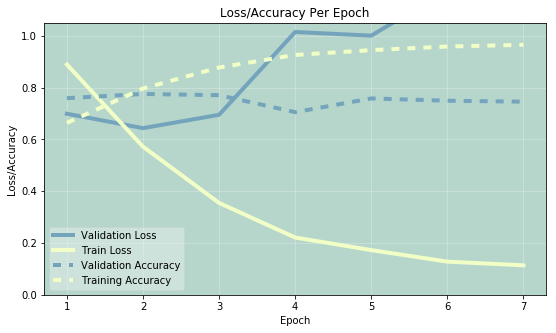

In [58]:
length = mini_history.shape[0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

ax.plot(1+np.arange(length), mini_batch.history['val_loss'], c='#74A4BC', lw=4)
ax.plot(1+np.arange(length), mini_batch.history['loss'], c='#F1FEC6', lw=4)
ax.plot(1+np.arange(length), mini_batch.history['val_acc'], c='#74A4BC', linestyle=(0, (2, 2)), lw=4)
ax.plot(1+np.arange(length), mini_batch.history['acc'], c='#F1FEC6', linestyle=(0, (2, 2)), lw=4)

ax.set_facecolor('#B6D6CC')
ax.legend(('Validation Loss', 'Train Loss', 
            'Validation Accuracy', 'Training Accuracy'), framealpha=0.3)
ax.set_title('Loss/Accuracy Per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/Accuracy')
ax.set_ylim(0, 1.05)
ax.grid(True, color='white', alpha=0.3)

##### Evaluating the model

In [59]:
metrics = model.evaluate(X_test, y_test)

3396/3396 [==============================] - 9s 3ms/sample - loss: 0.6887 - acc: 0.7697


In [60]:
temp = pd.DataFrame(metrics, index=model.metrics_names, columns=['Mini Batch'])
metrics_df = pd.concat([metrics_df, temp], axis=1, sort=False)
metrics_df

,First Attempt,Larger Kernel,Small Batch,Mini Batch
loss,1.055568,1.077414,0.655214,0.688713
acc,0.782686,0.766196,0.785630,0.769729


### Fifth model: no dropout layer

##### Building the model

In [61]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dense(128, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(6, activation='softmax')
    ])

##### Callbacks

In [62]:
early_stopping = EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)

##### Compiling the model

In [63]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

##### Model parameters

In [64]:
batch_size=32
epochs=25
validation_split=2e-1

##### Training the model

In [65]:
no_drop = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=validation_split, 
          callbacks=[early_stopping])

Train on 10866 samples, validate on 2717 samples
Epoch 1/25
10866/10866 [==============================] - 78s 7ms/sample - loss: 0.9723 - acc: 0.6368 - val_loss: 0.7530 - val_acc: 0.7155
Epoch 2/25
10866/10866 [==============================] - 78s 7ms/sample - loss: 0.6202 - acc: 0.7819 - val_loss: 0.8186 - val_acc: 0.7225
Epoch 3/25
10866/10866 [==============================] - 78s 7ms/sample - loss: 0.4123 - acc: 0.8620 - val_loss: 0.6672 - val_acc: 0.7744
Epoch 4/25
10866/10866 [==============================] - 78s 7ms/sample - loss: 0.2390 - acc: 0.9229 - val_loss: 0.7050 - val_acc: 0.7814
Epoch 5/25
10866/10866 [==============================] - 78s 7ms/sample - loss: 0.1341 - acc: 0.9577 - val_loss: 0.9165 - val_acc: 0.7641
Epoch 6/25
10866/10866 [==============================] - 78s 7ms/sample - loss: 0.0953 - acc: 0.9739 - val_loss: 0.9532 - val_acc: 0.7817
Epoch 7/25
10866/10866 [==============================] - 78s 7ms/sample - loss: 0.0421 - acc: 0.9901 - val_loss: 1.2

##### Model summary

In [66]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
dense_10 (Dense)             (None, 73, 73, 128)       8320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 165888)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 995334    
Total para

##### Epoch crosstab

In [67]:
no_drop_history = pd.DataFrame(no_drop.history)
no_drop_history.index += 1
no_drop_history

,loss,acc,val_loss,val_acc
1,0.972290,0.636849,0.753025,0.715495
2,0.620216,0.781888,0.818627,0.722488
3,0.412287,0.862047,0.667187,0.774383
4,0.239035,0.922879,0.704990,0.781377
5,0.134111,0.957666,0.916490,0.764078
6,0.095333,0.973863,0.953188,0.781745
7,0.042110,0.990061,1.276262,0.771807
8,0.056839,0.984815,1.346270,0.730217
9,0.050846,0.987024,1.430871,0.733162
10,0.029070,0.993006,1.457788,0.751932


##### Plotting the epochs

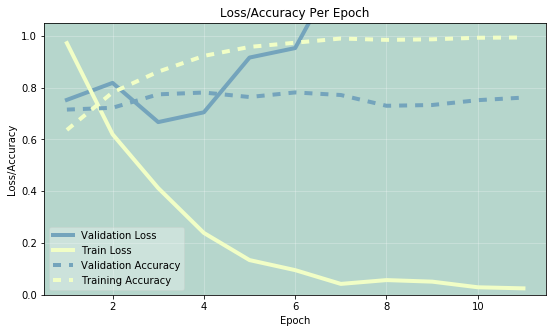

In [68]:
length = no_drop_history.shape[0]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

ax.plot(1+np.arange(length), no_drop.history['val_loss'], c='#74A4BC', lw=4)
ax.plot(1+np.arange(length), no_drop.history['loss'], c='#F1FEC6', lw=4)
ax.plot(1+np.arange(length), no_drop.history['val_acc'], c='#74A4BC', linestyle=(0, (2, 2)), lw=4)
ax.plot(1+np.arange(length), no_drop.history['acc'], c='#F1FEC6', linestyle=(0, (2, 2)), lw=4)

ax.set_facecolor('#B6D6CC')
ax.legend(('Validation Loss', 'Train Loss', 
            'Validation Accuracy', 'Training Accuracy'), framealpha=0.3)
ax.set_title('Loss/Accuracy Per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss/Accuracy')
ax.set_ylim(0, 1.05)
ax.grid(True, color='white', alpha=0.3)

##### Evaluating the model

In [69]:
metrics = model.evaluate(X_test, y_test)

3396/3396 [==============================] - 9s 3ms/sample - loss: 0.9546 - acc: 0.7765


In [70]:
temp = pd.DataFrame(metrics, index=model.metrics_names, columns=['No Dropout'])
metrics_df = pd.concat([metrics_df, temp], axis=1, sort=False)
metrics_df

,First Attempt,Larger Kernel,Small Batch,Mini Batch,No Dropout
loss,1.055568,1.077414,0.655214,0.688713,0.954556
acc,0.782686,0.766196,0.785630,0.769729,0.776502


### Final results

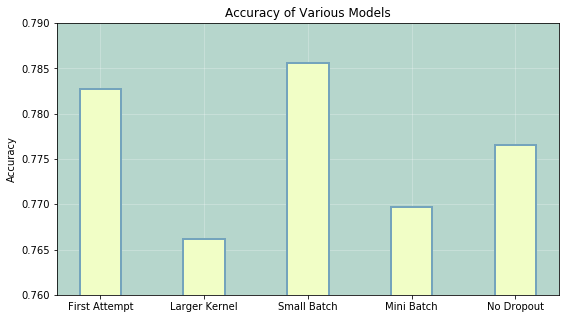

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))

ax.bar(metrics_df.columns, height=metrics_df.loc['acc', :].values, 
       color=['#F1FEC6'], width=4e-1, lw=2, edgecolor=['#74A4BC'])
ax.set_ylim(0.76, 0.79)
ax.set_facecolor('#B6D6CC')
plt.title('Accuracy of Various Models')
ax.set_ylabel('Accuracy')
ax.grid(True, color='white', alpha=0.3)
ax.set_axisbelow(True)
plt.show()